### Make plotly plots for measuring features in solar wind data

In [32]:
import pickle
import os
import numpy as np
from sunpy.time import parse_time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from heliocats import data as hd
import copy

data_path='/Users/chris/python/data/insitu_python/'

#Plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
pio.renderers.default = 'browser'

print(' ' )

#### print files in data_path

In [15]:
files = os.listdir(data_path)
files.sort()
fnames=[os.path.join(data_path, f) for f in files]
for item in files:
    print(item)

.DS_Store
ML_struct_arrays
bepi_ib_2019_now_e2k.p
bepi_ib_2019_now_rtn.p
bepi_ib_e2k_test.p
bepi_ib_rtn_test.p
bepi_ob_2019_now_e2k.p
bepi_ob_2019_now_rtn.p
bepi_ob_e2k_test.p
juno_2011_2016_rtn.p
maven_2014_2018_removed.p
maven_2014_2018_removed_smoothed.p
maven_2014_2021_removed_no_plasma.p
maven_2014_2021_removed_smoothed_no_plasma.p
messenger_2007_2015_sceq_removed.p
msl_2012_2019_rad.p
new_data_headers.txt
noaa_dst_last_300files_now.p
noaa_dst_last_35files_now.p
noaa_rtsw
noaa_rtsw_last_2500files_now.p
noaa_rtsw_last_300files_now.p
noaa_rtsw_last_35files_now.p
omni_1963_now.p
plots
plots_positions
plots_sun
positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_degrees.p
positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_rad.p
positions_psp_solo_sta_bepi_wind_planets_HEEQ_1hour_degrees.p
positions_psp_solo_sta_bepi_wind_planets_HEEQ_1hour_rad.p
predicted-solar-cycle-2023_apr_19.json
psp_2018_now_rtn.p
psp_rtn_test.p
rc_list.htm
solo_2020_now_rtn.p
solo_rtn_test.p
ssn.p
ssn_13ms.p
ss

In [19]:
#file='solo_2020_now_rtn.p'
#file='psp_2018_now_rtn.p'
file='bepi_ib_2019_now_rtn.p'
#file='bepi_ob_2019_now_rtn.p'
#file='stereoa_beacon_rtn_last_300days_now.p'
#file='wind_1995_now_rtn.p'
#file='solo_rtn_test.p'


[sc,header]=pickle.load(open(data_path+file, "rb" ) ) 

#cutout array for these dates
start=datetime(2022,3,10)
end=datetime(2022,4,10)

#scnum=mdates.date2num(sc.time)
startind=np.argmin(abs(start-sc.time))
endind=np.argmin(abs(end-sc.time))

sc=sc[startind:endind]

######## save cutout data if needed

#pickle_file='data/bepi_cutout_2022_march_10_april_10.p'
#pickle.dump([sc, header], open(pickle_file, "wb"))
#[bepi,hbepi]=pickle.load(open(pickle_file, "rb" ) )

#plt.plot(bepi.time,bepi.bt)
#plt.plot(bepi.time,bepi.bx)
#plt.plot(bepi.time,bepi.by)
#plt.plot(bepi.time,bepi.bz)
#header

In [30]:
file_sta_beacon_rtn='stereoa_beacon_rtn_last_35days_now.p'   
#load rtn
[sta_rtn,hsta]=pickle.load(open(data_path+file_sta_beacon_rtn, "rb" ) )  

In [48]:
def convert_RTN_to_GSE_sta_l1(sc_in):

    sc=copy.deepcopy(sc_in)

    print('conversion RTN to GSE') 
    
    heeq_bx=np.zeros(len(sc))
    heeq_by=np.zeros(len(sc))
    heeq_bz=np.zeros(len(sc))
    
    jd=np.zeros(len(sc))
    mjd=np.zeros(len(sc))
    
     
    ########## first RTN to HEEQ 
    
    #go through all data points
    for i in np.arange(0,len(sc)):

        #HEEQ vectors
        X_heeq=[1,0,0]
        Y_heeq=[0,1,0]
        Z_heeq=[0,0,1]

        #normalized X RTN vector
        Xrtn=[sc.x[i],sc.y[i],sc.z[i]]/np.linalg.norm([sc.x[i],sc.y[i],sc.z[i]])
        #solar rotation axis at 0, 0, 1 in HEEQ
        Yrtn=np.cross(Z_heeq,Xrtn)/np.linalg.norm(np.cross(Z_heeq,Xrtn))
        Zrtn=np.cross(Xrtn, Yrtn)/np.linalg.norm(np.cross(Xrtn, Yrtn))
        
        #project into new system
        heeq_bx[i]=np.dot(np.dot(sc.bx[i],Xrtn)+np.dot(sc.by[i],Yrtn)+np.dot(sc.bz[i],Zrtn),X_heeq)
        heeq_by[i]=np.dot(np.dot(sc.bx[i],Xrtn)+np.dot(sc.by[i],Yrtn)+np.dot(sc.bz[i],Zrtn),Y_heeq)
        heeq_bz[i]=np.dot(np.dot(sc.bx[i],Xrtn)+np.dot(sc.by[i],Yrtn)+np.dot(sc.bz[i],Zrtn),Z_heeq)
    
        #then HEEQ to GSE
        jd[i]=parse_time(sc.time[i]).jd
        mjd[i]=float(int(jd[i]-2400000.5))  #use modified julian date  
        
        #then lambda_sun
        T00=(mjd[i]-51544.5)/36525.0
        dobj=sc.time[i]
        UT=dobj.hour + dobj.minute / 60. + dobj.second / 3600. #time in UT in hours   
        LAMBDA=280.460+36000.772*T00+0.04107*UT
        M=357.528+35999.050*T00+0.04107*UT
        
        #lt2 is lambdasun in Hapgood, equation 5, here in rad
        lt2=(LAMBDA+(1.915-0.0048*T00)*np.sin(M*np.pi/180)+0.020*np.sin(2*M*np.pi/180))*np.pi/180
        
        #note that some of these equations are repeated later for the GSE to GSM conversion
        S1=np.matrix([[np.cos(lt2+np.pi), np.sin(lt2+np.pi),  0], [-np.sin(lt2+np.pi) , np.cos(lt2+np.pi) , 0], [0,  0,  1]])
        #create S2 matrix with angles with reversed sign for transformation HEEQ to HAE
        omega_node=(73.6667+0.013958*((mjd[i]+3242)/365.25))*np.pi/180 #in rad
        S2_omega=np.matrix([[np.cos(-omega_node), np.sin(-omega_node),  0], [-np.sin(-omega_node) , np.cos(-omega_node) , 0], [0,  0,  1]])
        inclination_ecl=7.25*np.pi/180
        S2_incl=np.matrix([[1,0,0],[0,np.cos(-inclination_ecl), np.sin(-inclination_ecl)], [0, -np.sin(-inclination_ecl), np.cos(-inclination_ecl)]])
        #calculate theta
        theta_node=np.arctan(np.cos(inclination_ecl)*np.tan(lt2-omega_node)) 

        #quadrant of theta must be opposite lt2 - omega_node Hapgood 1992 end of section 5   
        #get lambda-omega angle in degree mod 360   
        lambda_omega_deg=np.mod(lt2-omega_node,2*np.pi)*180/np.pi
        #get theta_node in deg
        theta_node_deg=theta_node*180/np.pi
        #if in same quadrant, then theta_node = theta_node +pi   
        if abs(lambda_omega_deg-theta_node_deg) < 180: theta_node=theta_node+np.pi
        S2_theta=np.matrix([[np.cos(-theta_node), np.sin(-theta_node),  0], [-np.sin(-theta_node) , np.cos(-theta_node) , 0], [0,  0,  1]])

        #make S2 matrix
        S2=np.dot(np.dot(S2_omega,S2_incl),S2_theta)
        #this is the matrix S2^-1 x S1
        HEEQ_to_HEE_matrix=np.dot(S1, S2)
        #convert HEEQ components to HEE
        HEEQ=np.matrix([[heeq_bx[i]],[heeq_by[i]],[heeq_bz[i]]]) 
        HEE=np.dot(HEEQ_to_HEE_matrix,HEEQ)
        #change of sign HEE X / Y to GSE is needed
        sc.bx[i]=-HEE[0]
        sc.by[i]=-HEE[1]
        sc.bz[i]=HEE[2]
    
    print('conversion RTN to GSE done') 
   
    return sc




sta_gse=convert_RTN_to_GSE_sta_l1(sta_rtn)




conversion RTN to GSE
conversion RTN to GSE done


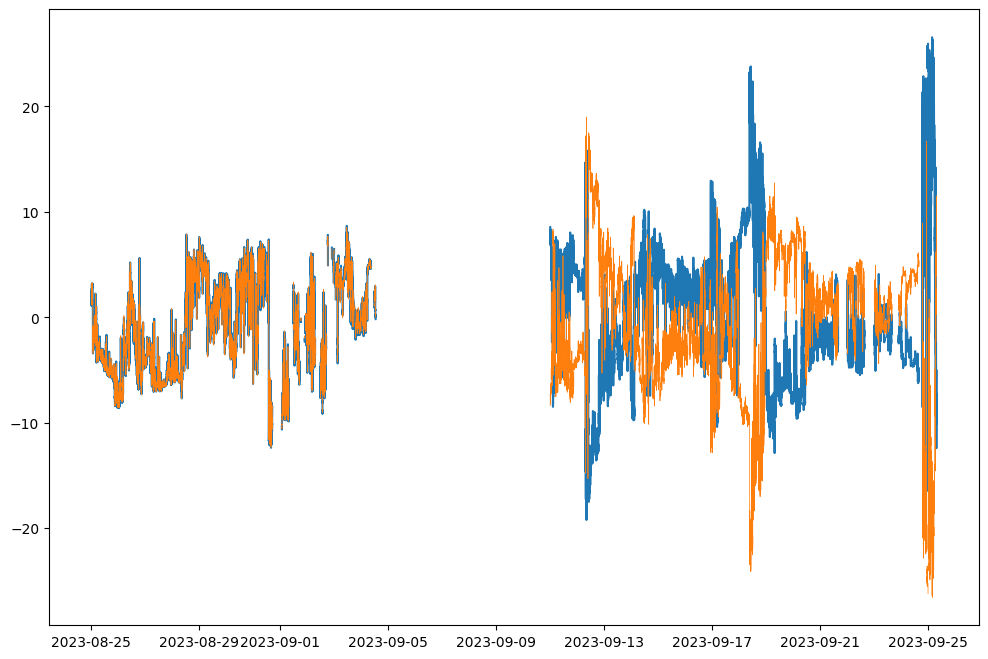

In [53]:
plt.figure(figsize=(12,8),dpi=100)

plt.plot(sta_rtn.time,sta_rtn.by)
plt.plot(sta_gse.time,-sta_gse.by,linewidth=0.5)

#plt.plot(sta_rtn.time,sta_rtn.bx)
#plt.plot(sta_gse.time,sta_gse.bx,linewidth=0.5)

In [25]:

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

#for column, color in zip(['b_x', 'b_y', 'b_z', 'b_tot'], ['red', 'green', 'blue', 'black']):
fig.add_trace(go.Scatter(x=sta_rtn.time, y=sta_rtn.by, name='By rtn',line_color='red'), row=1, col=1)
fig.add_trace(go.Scatter(x=sta_gsm.time, y=sta_gsm.by, name='By gsm',line_color='green'), row=1, col=1)



### Use plotly for measuring times

#### with plasma data


In [4]:
nrows=5
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.3,0.2, 0.2, 0.2, 0.1])


#for column, color in zip(['b_x', 'b_y', 'b_z', 'b_tot'], ['red', 'green', 'blue', 'black']):
fig.add_trace(go.Scatter(x=sc.time, y=sc.bx, name='Bx',line_color='red'), row=1, col=1)
fig.update_yaxes(title_text="B [nT] RTN", row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.by, name='By',line_color='green'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bz, name='Bz',line_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bt, name='Bt',line_color='black'), row=1, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.vt, name='Vt',line_color='black'), row=2, col=1)
fig.update_yaxes(title_text="V [km/s]", row=2, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.np, name='Np',line_color='black'), row=3, col=1)
fig.update_yaxes(title_text="Np [ccm-3]", row=3, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.tp, name='Tp',line_color='black'), row=4, col=1)
fig.update_yaxes(title_text="Tp [K]", row=4, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.r, name='R',line_color='black'), row=5, col=1)
fig.update_yaxes(title_text="R [AU]", row=5, col=1)


#fig.update_layout(title='sc data')

fig.write_html(f'measure.html')
fig.show()

### no plasma data

In [12]:
#def on_plot_click(trace, points, state):
#    if points.point_inds:
#        clicked_index = points.point_inds[0]
#        clicked_x = df['x_values'][clicked_index]
#        clicked_y = df['y_values'][clicked_index]
#        print(f"Clicked on point ({clicked_x}, {clicked_y})")


nrows=3
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.6, 0.2,0.2])

#for column, color in zip(['b_x', 'b_y', 'b_z', 'b_tot'], ['red', 'green', 'blue', 'black']):
fig.add_trace(go.Scatter(x=sc.time, y=sc.bx, name='Bx',line_color='red'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.by, name='By',line_color='green'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bz, name='Bz',line_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bt, name='Bt',line_color='black'), row=1, col=1)
fig.update_yaxes(title_text="B [nT] RTN", row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.r, name='R',line_color='black'), row=2, col=1)
fig.update_yaxes(title_text="R [AU]", row=2, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.lon, name='Longitude',line_color='black'), row=3, col=1)
fig.update_yaxes(title_text="longitude [deg] HEEQ", row=3, col=1)

# Attach the custom click event callback
#fig.data[0].on_click(on_plot_click)

fig.show()
#fig.update_layout(title='Wind')

#fig.write_html(f'measure_mag.html')


In [18]:


#check positions in positions file and in data file

#plt.plot(solo.time,solo.lat,'b-')
#plt.plot(pos[1].time,np.rad2deg(pos[1].lat),'k-')   

#from plotly.subplots import make_subplots
#fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
#fig.add_trace(go.Scatter(x=solo.time, y=solo.lat, name='lat solo',line_color='red'))
#fig.add_trace(go.Scatter(x=mdates.num2date(pos[1].time), y=np.rad2deg(pos[1].lat), name='lat pos',line_color='green'))

#fig.write_html(f'measure.html')


In [42]:
#print('load Solar Orbiter SCEQ')
#filesolo='solo_2020_april_2022_sep_mag_sceq.p'
#solo=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=solo
#sc_label='Solar Orbiter'
#start1='2022-Jan-1 00:00'
#end1='2022-Jun-30 00:00'


#print('load Solar Orbiter SCEQ')
#filesolo='solo_2020_april_2022_june_rtn.p'
#solo=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=solo
#sc_label='Solar Orbiter'
#start1='2022-Jan-1 00:00'
#end1='2022-Jun-30 00:00'

#print('PSP SCEQ')
#filepsp='psp_2022_add_mag_sceq.p'
#psp=pickle.load(open(data_path+filepsp, "rb" ) ) 
#filepsp='psp_2022_add_mag_rtn.p'
#psp=pickle.load(open(data_path+filepsp, "rb" ) ) 

#sc=psp
#sc_label='PSP'
#start1='2022-Jan-1 00:00'
#end1='2022-Mar-31 00:00'


#print('wind HEEQ')
#filesolo='wind_2018_now_heeq.p'
#[wind,windh]=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=wind
#sc_label='Wind'
#start1='2022-Sep-1 00:00'
#end1='2022-Nov-11 00:00'


#print('load bepi')
#file='bepi_2021_2022_ib_sceq.p'
#file='bepi_2021_2022_ib_sceq.p'

#bepi=pickle.load(open(data_path+file, "rb" ) ) 
#sc=bepi
#sc_label='Bepi'
#start1='2022-Apr-1 00:00'
#end1='2022-Nov-31 00:00'


#print('load sta')
#filesolo='stereoa_2020_now_sceq_beacon.p'
#[sta,stah]=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=sta
#sc_label='STEREO-A'
#start1='2022-Feb-1 00:00'
#end1='2022-Nov-11 00:00'



####### select parts for plotting
sc=sc[-100000:-1]

#sc[0:1]

